# Sampling from a bimodal normal distribution using Sequential Monte Carlo

This example shows how Sequential Monte Carlo can be used to sample from a bimodal normal distribution. If the object passed to Pints is not of type log_posterior - as here where a log_pdf is passed instead - then we assume independent uniform priors between -100 and 100, for each dimension.

In Sequential Monte Carlo, a series of tempered distributions are sampled from, whose density has the form,

$\beta \; \text{log} \; p(\theta|x) + (1-\beta) \; \text{log} \; p(\theta)$,

where $p(\theta|x)$ is the posterior and $p(\theta)$ is the prior, and $\beta\in(0,1]$ is a (inverse-)temperature parameter. By default, Pints uses a series of temperatures which are uniform on the log scale. Note that, when $\beta=1$, the density of the tempered distribution matches the posterior.

Show the distribution we aim to sample from.

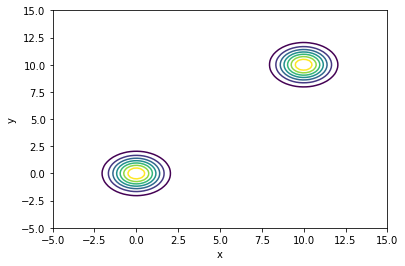

In [1]:
import os
os.chdir('../')
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.MultimodalNormalLogPDF()

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Sampling
Setup the sampler and run it.

In [2]:
# Select mean and variance matrix of initial proposal dist
x0 = [5, 5]
sigma0 = [[2, 0], [0, 2]]

# Create mcmc routine
sampler = pints.SMC(log_pdf, x0, sigma0)

# Set number of temperatures (uniform on log scale)
sampler.set_temperature_schedule(10)

# Set number of particles
sampler.set_particles(5000)

# Set number of MCMC steps at each temperature
sampler.set_kernel_samples(1)

# Run sampler
samples = sampler.run()

Running Sequential Monte Carlo
Total number of particles: 5000
Number of temperatures: 10
Resampling at end of each iteration
Number of MCMC steps at each temperature: 3
Temperature Eval. Time m:s
 0.99972    21000   0:11.4
 0.99923    36000   0:22.8
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

IndexError: string index out of range

In [ ]:
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Post estimation

Look at distribution of weights on final particles.

In [ ]:
weights = sampler.weights()
plt.hist(weights)
plt.show()

Print the effective sample size based on the formula,

$ess = \frac{1}{\sum_{i=1}^k w_i^2},$

where $w_i$ is the weight of particule $i$.

In [ ]:
print('ess = ', sampler.ess())

In [ ]:
np.log(0.8)

In [ ]:
mcmc = pints.AdaptiveCovarianceMCMC(x0, sigma0)

In [ ]:
mcmc._current = [5, 5]

In [ ]:
weights = np.copy(sampler.weights())
print(weights)

In [ ]:
sampler._weights = np.copy(weights)
print(sampler._weights)
samples_log_pdf_old = np.copy(sampler._samples_log_pdf_old)
samples_old = np.copy(sampler._samples_old)
samples_new = np.copy(sampler._samples)
_log_posterior = sampler._log_posterior
_log_prior = sampler._log_prior
sampler._new_weights(0.8, 1.0)
print(sampler._weights)

In [ ]:
from scipy.special import logsumexp
def _w_tilde(x_old, x_new, beta_old, beta_new):
    """
    Calculates the log unnormalised incremental weight as per eq. (31) in
    Del Moral.
    """
    return _tempered_distribution(x_old, beta_new) - _tempered_distribution(x_old, beta_old)

def _new_weight(w_old, x_old, x_new, beta_old, beta_new):
    """
    Calculates the log new weights as per algorithm 3.1.1. in Del Moral et
    al. (2006).
    """
    w_tilde_value = _w_tilde(x_old, x_new, beta_old, beta_new)
    return w_old + w_tilde_value

def _new_weights(w_old, samples_old, samples_new, beta_old, beta_new):
    """
    Calculates the new weights as per algorithm 3.1.1 in Del Moral et al.
    (2006).
    """
    w_new = np.array([
          _new_weight(
              w, samples_old[i], samples_new[i], beta_old, beta_new)
          for i, w in enumerate(w_old)])

    return w_new
def _tempered_distribution(x, beta):
    """
    Returns the tempered log-pdf:
    ``beta * log pi(x) + (1 - beta) * log prior(x)``
    If not explicitly given prior is assumed to be multivariate normal.
    """
    return beta * _log_posterior(x) + (1 - beta) * _log_prior(x)

In [ ]:
_w_tilde(samples_old[0], samples_new[0], 0.8, 1)

In [ ]:
sampler._w_tilde(samples_log_pdf_old[0], _log_prior(samples_old[0]), 0.8, 1)

In [ ]:
w1 = _new_weights(weights, samples_old, samples_new, 0.8, 1)

In [ ]:
_new_weight(weights[0], samples_old[0], samples_new[0], 0.8, 1.0)

In [ ]:
sampler._new_weight(weights[0], samples_log_pdf_old[0], _log_prior(samples_old[0]), 0.8, 1)

In [ ]:
weights_temp = np.zeros(len(weights))
for i, w in enumerate(weights):
    fx_old = samples_log_pdf_old[i]
    f_prior_old = _log_prior(samples_old[i])
    weights_temp[i] = sampler._new_weight(w, fx_old,
                                                f_prior_old,
                                                0.8, 1)
print(len(weights_temp))

In [ ]:
diff = w1 - weights_temp

In [ ]:
diff[0:100]

In [ ]:
_w_tilde(samples_old[3], samples_new[3], 0.8, 1)

In [ ]:
sampler._w_tilde(samples_log_pdf_old[3], _log_prior(samples_old[3]), 0.8, 1)

In [ ]:
_log_posterior(samples_old[3])

In [ ]:
samples_log_pdf_old[3]

In [ ]:
samples_old[3]